In [20]:
# Might need to install some extra dependencies first to run this:
# !pip install --user vega seaborn
# !jupyter nbextension install --user --py vega3
# !jupyter nbextension enable vega3 --user --py

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 6
rcParams['figure.dpi'] = 150

In [3]:
# These functions will soon move into fast-manipulator / fast-plotter
import re
import os
import numpy as np
import pandas as pd

# Interpret the filename
def get_read_options(filename):
    decipher = re.compile(r"tbl_(?P<index>.*?)(|--(?P<weights>.*))\.csv")
    groups = decipher.match(os.path.basename(filename))
    
    index_cols = groups.group("index").split(".")
    options = dict(index_col = range(len(index_cols)),
                   comment = "#"
                   )
    return options
    
def read_binned_df(filename):
    return pd.read_csv(filename, **get_read_options(filename))

def split_df(df, first_values, level=0):
    second = df.drop(first_values, level=level)
    second_values = second.index.unique(level=level)
    first = df.drop(second_values, level=level)
    return first, second

def split_data_sims(df, data_labels=["data"], dataset_level="dataset"):
    return split_df(df, first_values=data_labels, level=dataset_level)

def calculate_error(df, sumw2_label="sumw2", err_label="err", inplace=True):
    if not inplace:
        df = df.copy()
    for column in df:
        if sumw2_label in column:
            err_name = column.replace(sumw2_label, err_label)
            df[err_name] = np.sqrt(df[column])
    if not inplace:
        return df

def stack_sims(df, data_labels=["data"], dataset_level="dataset"):
    data, sims = split_data_sims(df, data_labels=data_labels, dataset_level=dataset_level)
    dataset_level_no = sims.index.names.index(dataset_level)
    group_levels = range(sims.index.nlevels)
    group_levels.remove(dataset_level_no)
    sim_stacked = sims.groupby(level=group_levels).cumsum()
    return data.append(sim_stacked)

def interval_from_string(df, sumw2_label="variance", err_label="err", inplace=True):
    if not inplace:
        df = df.copy()
    for column in df:
        if df[column].dtype:
            pass
    if not inplace:
        return df    

## Load in the data

In [4]:
!column -s, -t "example_outputs/tbl_dataset.nMuons.nIsoMuons--weighted.csv" |head

dataset     nMuons  nIsoMuons  n         weighted:sumw  weighted:sumw2
data        0       0          227265.0  227265.0       227265.0
data        1       0          17795.0   17795.0        17795.0
data        1       1          205616.0  205616.0       205616.0
data        2       0          107.0     107.0          107.0
data        2       1          2393.0    2393.0         2393.0
data        2       2          16207.0   16207.0        16207.0
data        3       3          1.0       1.0            1.0
dy          0       0          2181.0    787.2786       553.8454
dy          1       0          2472.0    910.05237      678.6613


In [5]:
muons = read_binned_df("example_outputs/tbl_dataset.nMuons.nIsoMuons--weighted.csv")
muons.head(10)

n  weighted:sumw  weighted:sumw2
dataset nMuons nIsoMuons                                         
data    0      0          227265.0   227265.00000     227265.0000
        1      0           17795.0    17795.00000      17795.0000
               1          205616.0   205616.00000     205616.0000
        2      0             107.0      107.00000        107.0000
               1            2393.0     2393.00000       2393.0000
               2           16207.0    16207.00000      16207.0000
        3      3               1.0        1.00000          1.0000
dy      0      0            2181.0      787.27860        553.8454
        1      0            2472.0      910.05237        678.6613
               1           29027.0    13163.78700       9294.2890

## Project 2D to 1D vs datasets

In [7]:
muons_1d = muons.groupby(level=("dataset", "nMuons")).sum()
muons_1d.head(8)

n  weighted:sumw  weighted:sumw2
dataset nMuons                                         
data    0       227265.0  227265.000000   227265.000000
        1       223411.0  223411.000000   223411.000000
        2        18707.0   18707.000000    18707.000000
        3            1.0       1.000000        1.000000
ttbar   0        30856.0    6590.466000     1715.456500
        1         5792.0    1273.098125      334.434816
        2          293.0      65.912060       17.500874
wjets   0         7080.0   11070.950000    23975.477000

In [8]:
muons_1d = calculate_error(muons_1d, inplace=False)
muons_1d.head(8)

n  weighted:sumw  weighted:sumw2  weighted:err
dataset nMuons                                                       
data    0       227265.0  227265.000000   227265.000000    476.723190
        1       223411.0  223411.000000   223411.000000    472.663728
        2        18707.0   18707.000000    18707.000000    136.773535
        3            1.0       1.000000        1.000000      1.000000
ttbar   0        30856.0    6590.466000     1715.456500     41.418070
        1         5792.0    1273.098125      334.434816     18.287559
        2          293.0      65.912060       17.500874      4.183405
wjets   0         7080.0   11070.950000    23975.477000    154.840166

## Plotting 1D Data vs MC using Vega-lite
Plot things using Vega-lite:  
* Not a complete solution yet, eg: errorbars not working in notebook, etc, but is a way to go for the future
* Advantages: Reproducibility, interactivity

In [12]:
# Stack the values from MC; Vega-lite should be able to do this, but I've had problems...
stacked_df = stack_sims(muons_1d)

n  weighted:sumw  weighted:sumw2  weighted:err
dataset nMuons                                                       
data    0       227265.0  227265.000000   227265.000000    476.723190
        1       223411.0  223411.000000   223411.000000    472.663728
        2        18707.0   18707.000000    18707.000000    136.773535
        3            1.0       1.000000        1.000000      1.000000
ttbar   0        30856.0    6590.466000     1715.456500     41.418070
        1         5792.0    1273.098125      334.434816     18.287559
        2          293.0      65.912060       17.500874      4.183405
wjets   0        37936.0   17661.416000    25690.933500    196.258236
        1       108447.0  199803.193125   451301.498816    689.828372
        2          295.0      68.414263       22.395518      6.395789

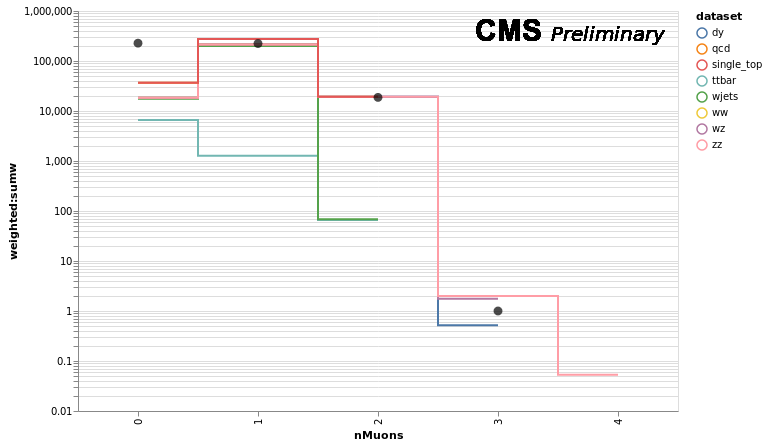

In [18]:
spec = {
   '$schema': 'https://vega.github.io/schema/vega-lite/v2.json',
   'config': {},
   'width': 600,
   'height': 400,
   'layer': [{
       "selection": {"grid": {"type": "interval", "bind": "scales"}},
       "mark": {"type": "line", "interpolate": "step","tooltip": {"field": ""}},
       "encoding": {
           "y": {
               "field": "weighted:sumw",
               "type": "quantitative", 
               "scale": {"type": "log", "domain": [0.01]}
           },
           "tooltip": [{"field": "weighted:sumw"}, {"field": "weighted:err"}],
           "color": {"field": "dataset", "type": "nominal"}
       },
       "transform": [{"filter": "datum.dataset != 'data'"}]
   },{
       "mark": {"type": "point", "filled": "true", "size": 80, "color": "black"},
       "encoding": {
           "y": {"field": "weighted:sumw","type": "quantitative"},
           "tooltip": [{"field": "weighted:sumw"}, {"field": "weighted:err"}]
       },
       "transform": [{"filter": "datum.dataset == 'data'"}]
   },{
       "mark": {"type": "text", "text": "CMS", "size": 30, "font": "Arial", "fontWeight": "bold"},
       "encoding": {"x": {"value": 430}, "y": {"value": 30}}
   },{
       "mark": {"type": "text", "text": "Preliminary", "size": 20, "fontStyle": "italic", "fontWeight": 5},
       "encoding": {"x": {"value": 530}, "y": {"value": 30}}
   }
   ],
    'encoding': {
        "x": {"field": "nMuons", "type": "ordinal", "grid": "true"}
    }
}
from vega import VegaLite
plot = VegaLite(spec, stacked_df.reset_index())
plot

## Plotting 1D Data vs MC using Matplotlib and built-in pandas

In [9]:
mu_data, mu_sims = split_data_sims(muons_1d)
mu_data

n  weighted:sumw  weighted:sumw2  weighted:err
dataset nMuons                                                       
data    0       227265.0       227265.0        227265.0    476.723190
        1       223411.0       223411.0        223411.0    472.663728
        2        18707.0        18707.0         18707.0    136.773535
        3            1.0            1.0             1.0      1.000000

In [11]:
mu_sims.head()

n  weighted:sumw  weighted:sumw2  weighted:err
dataset nMuons                                                       
ttbar   0        30856.0    6590.466000     1715.456500     41.418070
        1         5792.0    1273.098125      334.434816     18.287559
        2          293.0      65.912060       17.500874      4.183405
wjets   0         7080.0   11070.950000    23975.477000    154.840166
        1       102655.0  198530.095000   450967.064000    671.540813

Text(0.64,0.932,'Preliminary')

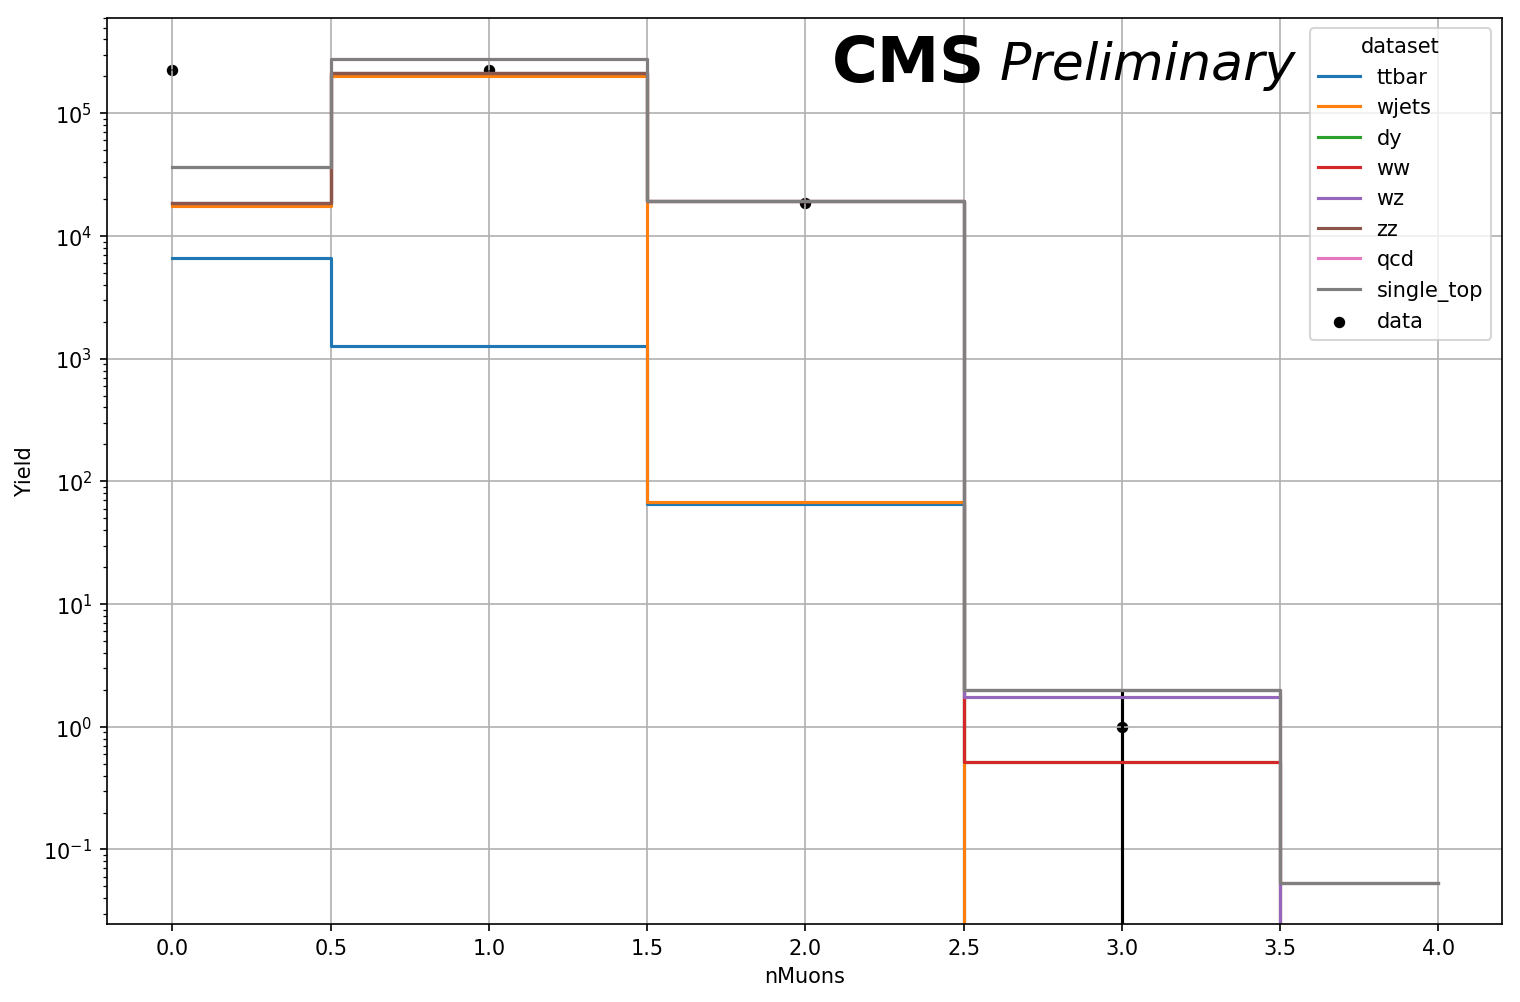

In [17]:
ax = plt.subplot(111)

mu_sims["weighted:sumw"].unstack(0).plot.line(drawstyle="steps-mid", logy=True, stacked=True, figsize=(12, 8), ax=ax)
mu_data.reset_index().plot.scatter(x="nMuons", y="weighted:sumw", yerr="weighted:err", color="k", label="data", ax=ax)

plt.grid(True)
plt.ylabel("Yield")
plt.annotate("CMS", (0.52, 0.93), xycoords="axes fraction",fontsize=30, fontweight="bold")
plt.annotate("Preliminary", (0.64, 0.932), xycoords="axes fraction",fontsize=25, fontstyle="italic")

## 2D heat-map plots

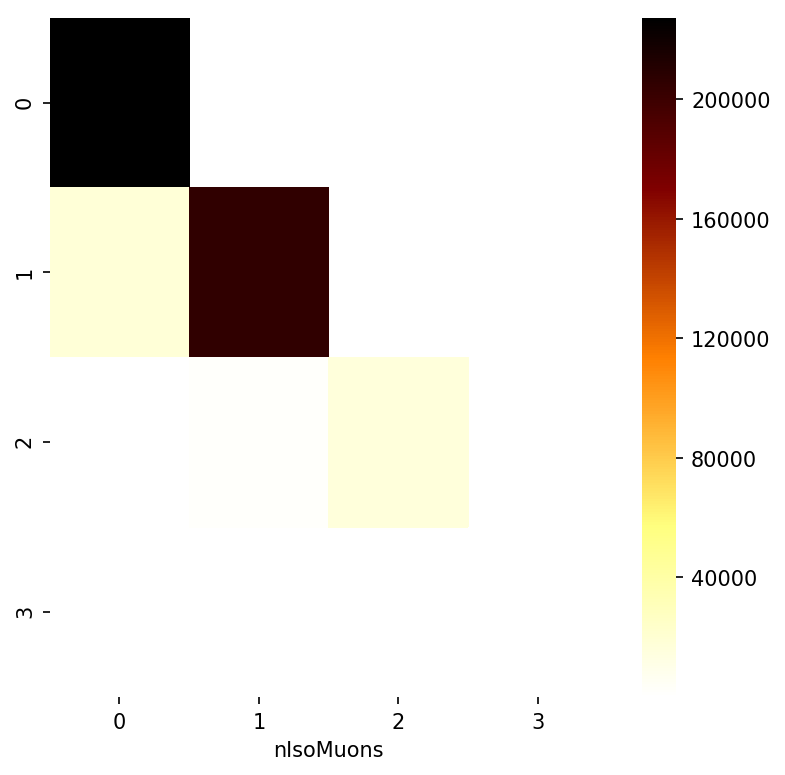

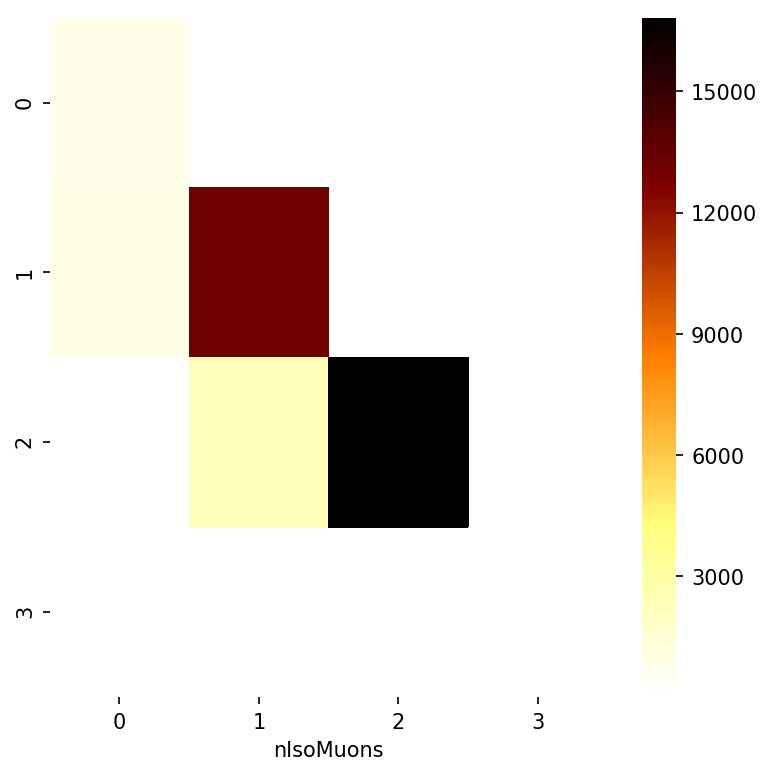

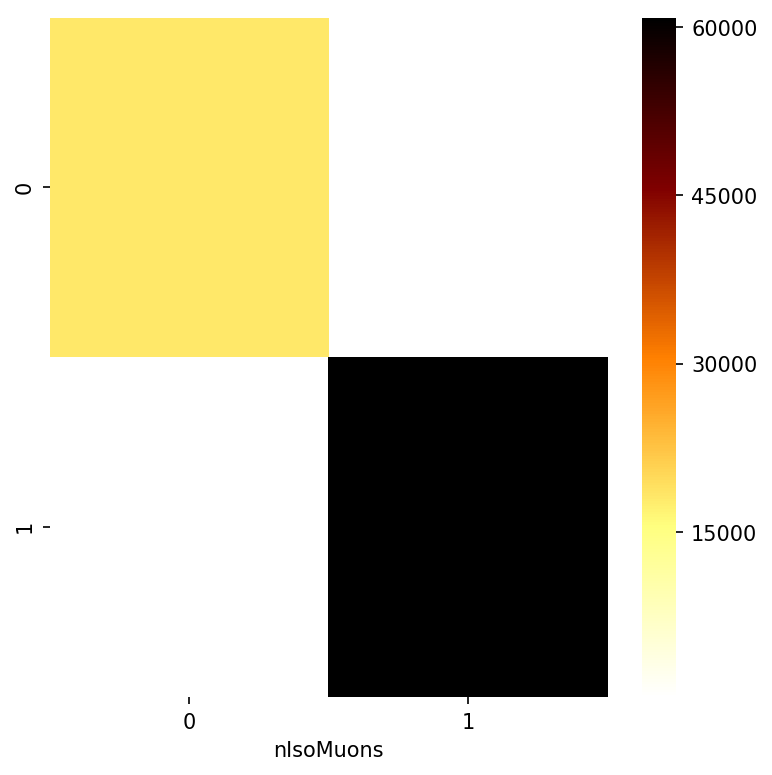

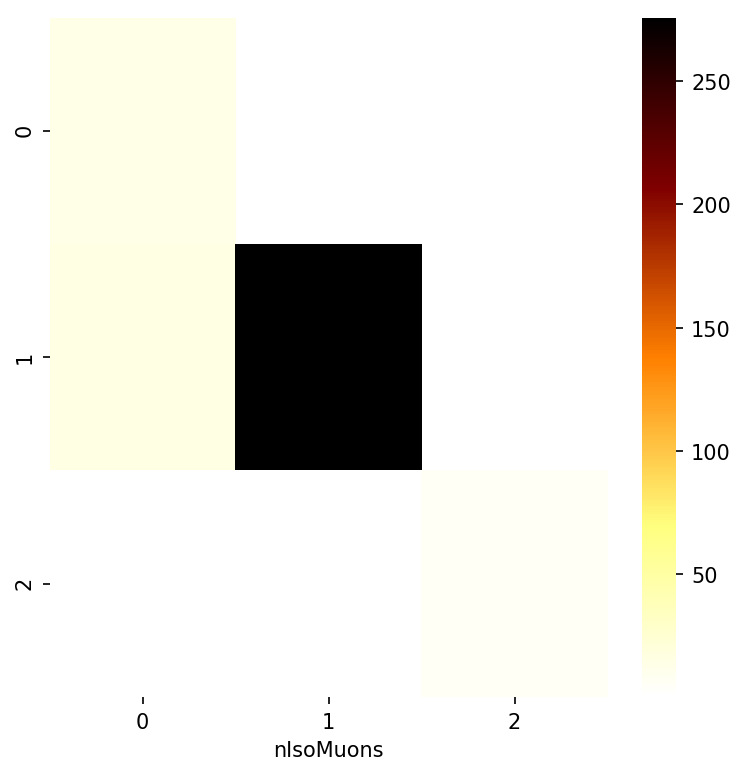

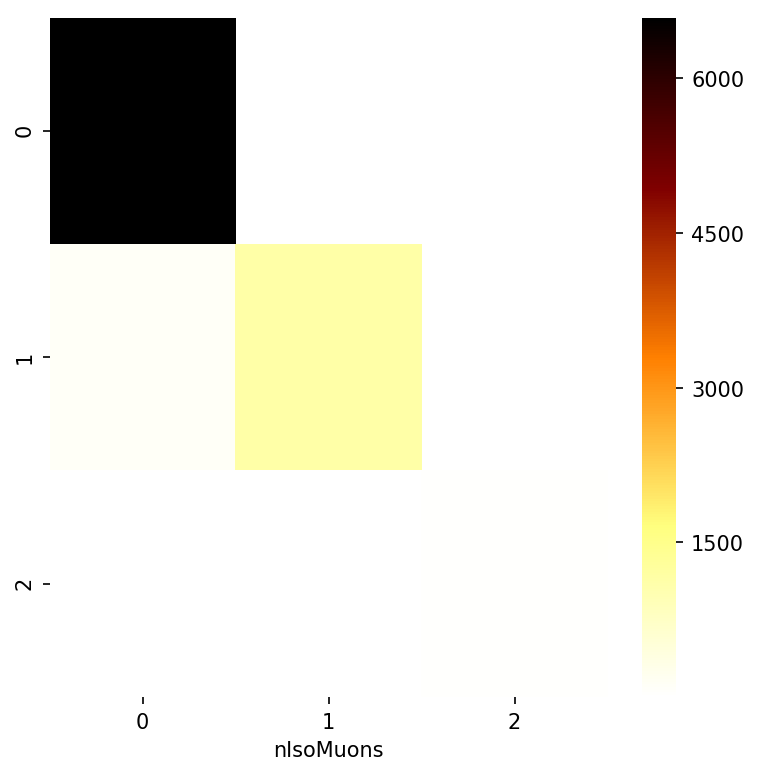

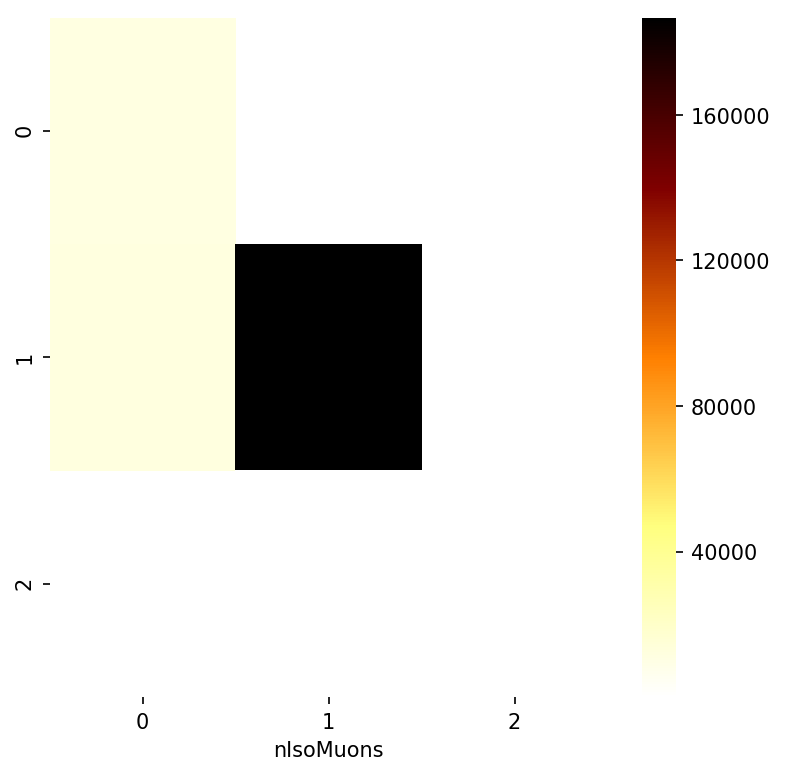

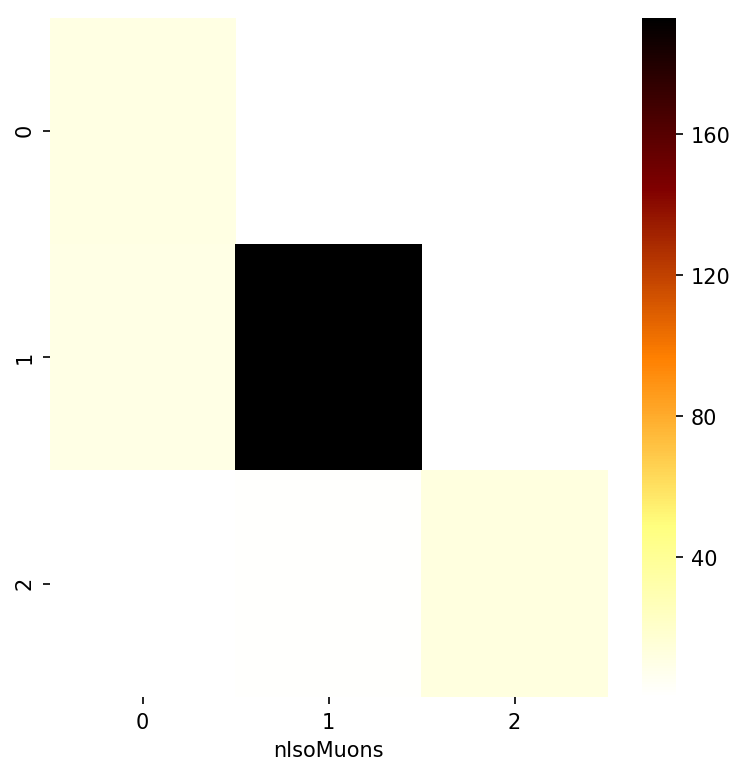

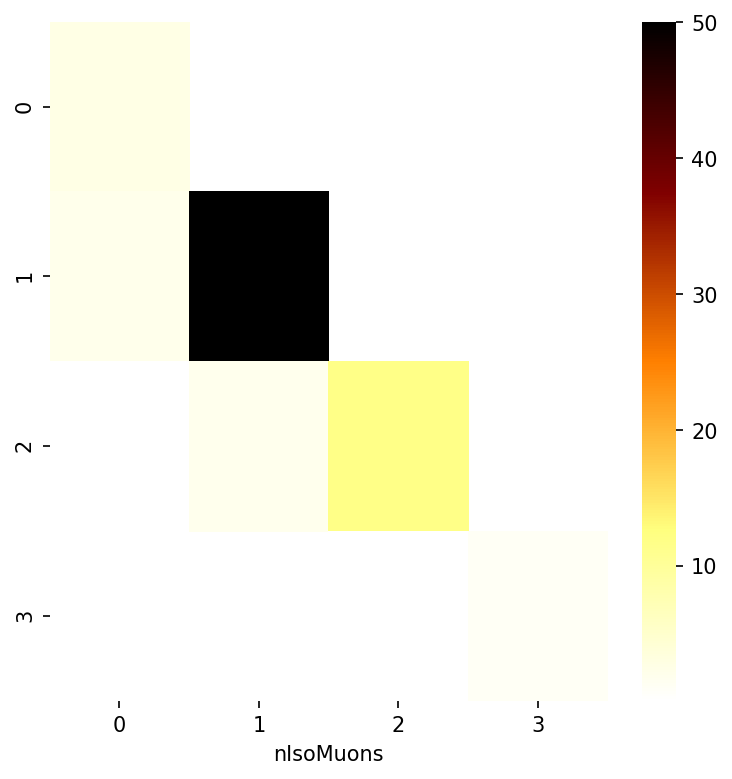

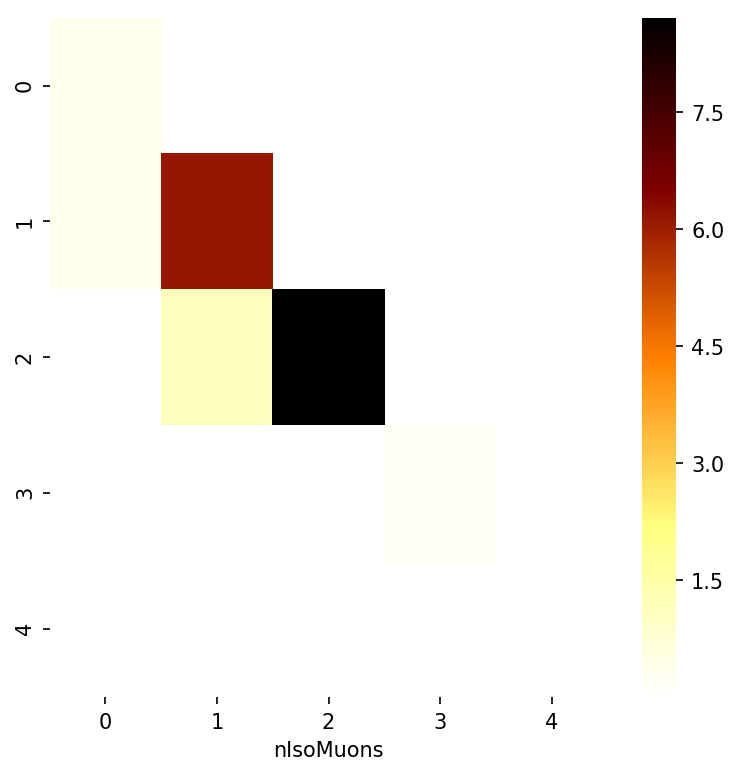

In [23]:
import seaborn as sns

values = "weighted:sumw"
y = "nMuons"
x = "nIsoMuons"
dataframe = muons.reset_index()
for dataset, group in dataframe.groupby("dataset"):
    df = group.pivot(index=y, columns=x, values=values)
    df = df.reset_index(0, drop=True)
                                      
    plt.figure()
    sns.heatmap(df, cmap="afmhot_r")